In [1]:
%matplotlib inline
# %matplotlib widget

from functools import partial
from pathlib import Path

import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

from plothelper import *

Matplotlib Version: 3.7.1


In [2]:
def milliMolarToNumberDensity(c: float) -> float:
    """Convert mM to #nm^-3

    Args:
        c (float): Input concentration

    Returns:
        float: Output number density in #nm^-3 units
    """
    return c * 6.022e-4


In [3]:
def computeForce(
    cp: float,
    phi: float,
    # s0: float,
    i: int,
    a: float,
    alpha: float,
    A: float,
    B: float,
    d: float,
    N: int,
    verbose: bool = False,
) -> float:
    """_summary_

    Args:
        cp (float): Protein concentration in mM
        phi (float): Ionic concentration in mM
        s0 (float): Baseline area per chain nm^2
        i (int): Geometry index 1=plane; 2=cylinder; 3=sphere
        a (float): Monomer/Kuhn length in nm
        alpha (float): Degree of ionization
        A (float): Second virial coefficient
        B (float): Third virial coefficient
        N (float): Number of units

    Returns:
        float: _description_
    """
    if N * a < d:
        raise RuntimeError(
            f"Protein thickness (d={d}) is greater than stretched polymer (Na={N*a})"
        )

    cp = milliMolarToNumberDensity(cp)
    phi = milliMolarToNumberDensity(phi)

    if cp == 0:
        F_elastic = 0
        F_virial = 0
        F_ion = 0

    else:
        s0 = N / (d * cp)

        if verbose:
            print(f"N = {N}, len = {N*a} nm, d = {d} nm, s0 = {s0} nm^2")

        F_elastic = 1.5 / (
            cp * s0 * a * a
        )  # (in units of kBT) elastic energy of the chain

        F_virial = (A * cp * cp + B * cp * cp * cp) * s0

        if phi == 0:
            F_ion = 0
        else:
            acop = alpha * cp / phi
            sopacop2 = np.sqrt(1 + acop * acop)
            F_ion = (-(sopacop2 - 1) * phi - alpha * cp * np.log(sopacop2 - acop)) * s0

    if verbose:
        print(f"elastic {F_elastic}, virial {F_virial},  ion {F_ion}")
        print(f"{F_elastic + F_ion + F_virial} nm^-1")
    return F_elastic + F_ion + F_virial


In [18]:
plot3D = True

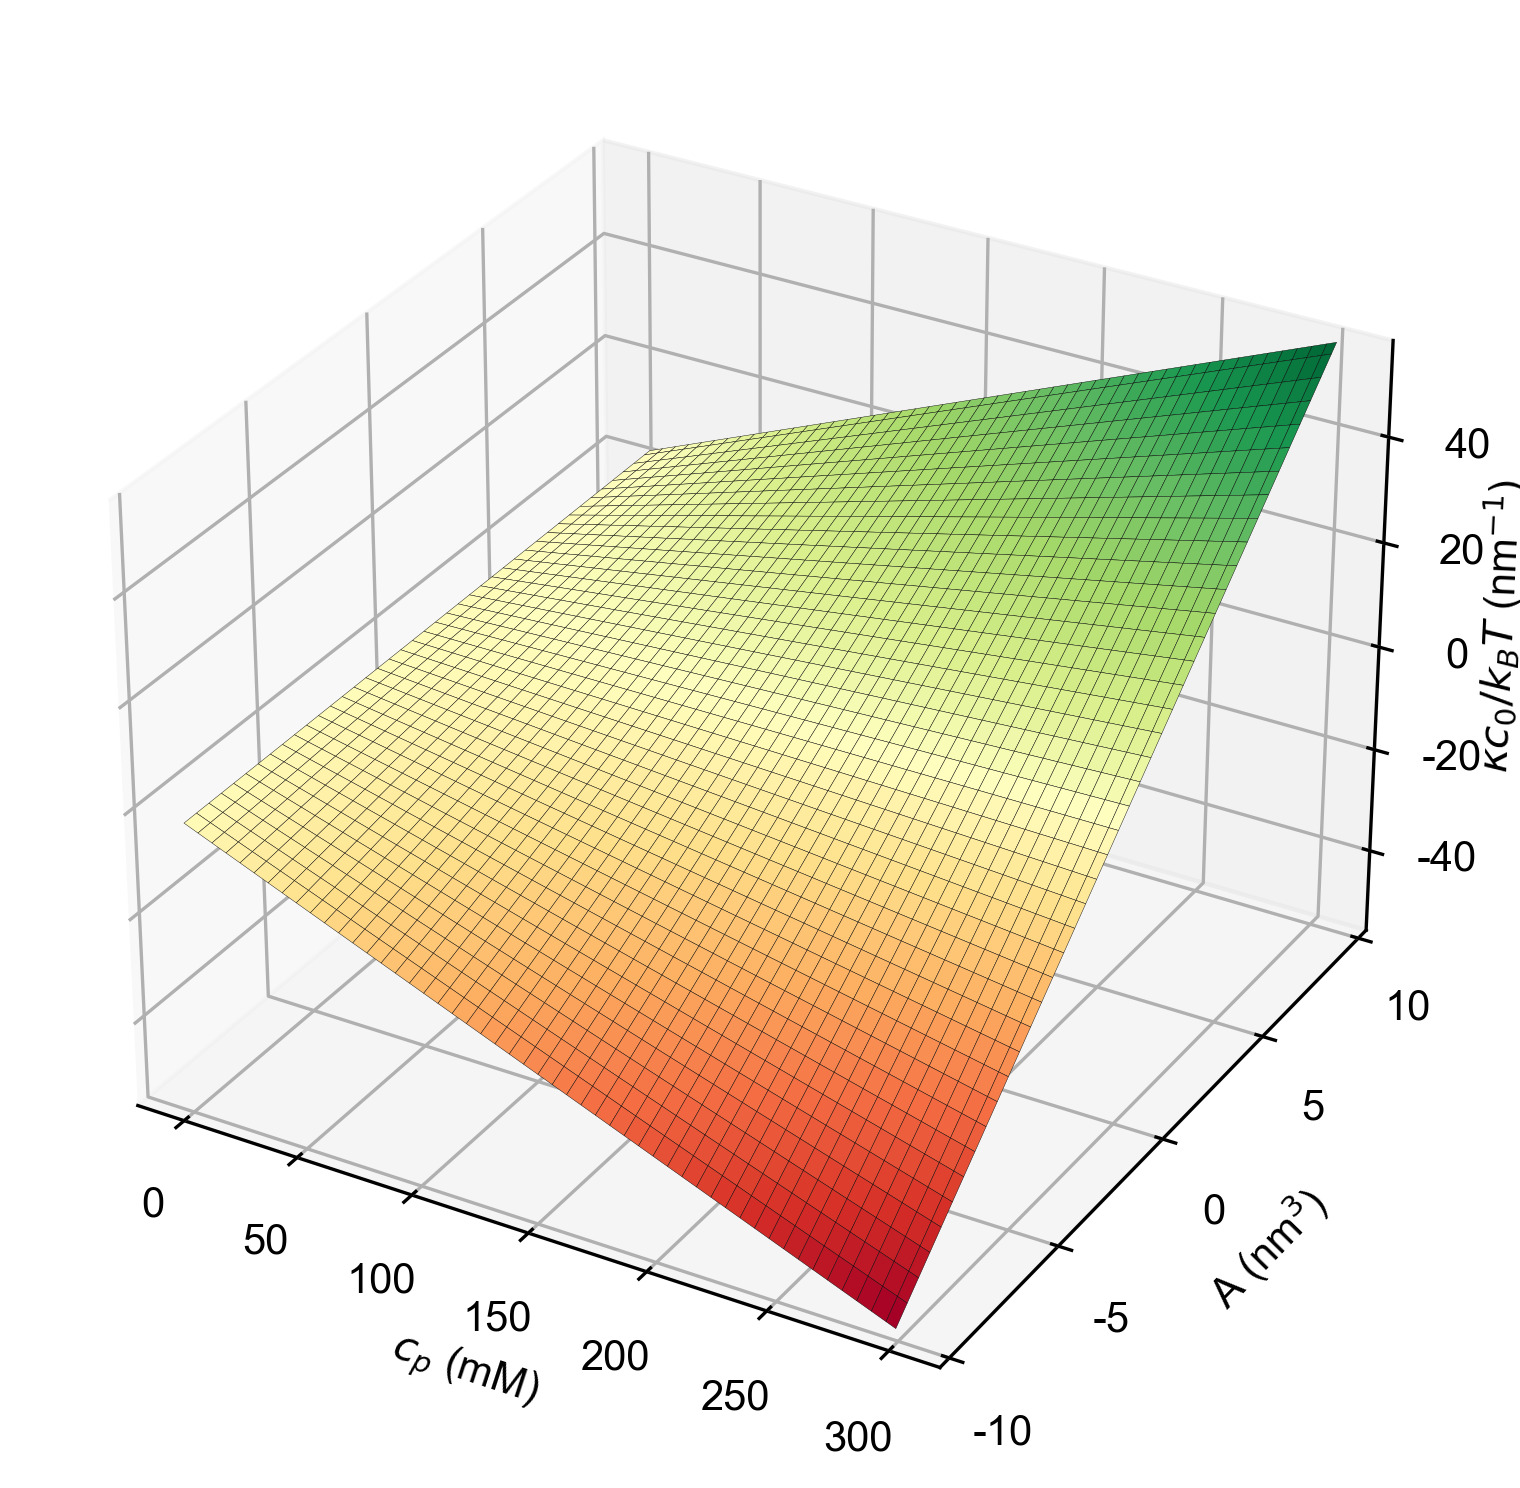

In [20]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


if plot3D:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
else:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.set_box_aspect(aspect = (1,1,1))

cps = np.arange(1, 300, 1)
As = np.arange(-10, 10.5, 0.25)

# print(len(cps), len(As))
Z = np.zeros(
    (
        len(As),
        len(cps),
    )
)

for i, cp in enumerate(cps):
    for j, A in enumerate(As):
        Z[j, i] = computeForce(
            cp=cp, A=A, phi=150, i=1, a=1.0, alpha=0.1, B=0, d=20, N=600
        )


cp, A = np.meshgrid(cps, As)

if plot3D:
    ax.plot_surface(
        cp, A, Z, cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor="k"
    )

    # surf = ax.scatter(
    #     cp[Z>0], A[Z>0], Z[Z>0], cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor="k"
    # )

    # surf = ax.scatter(
    #     cp[Z<0], A[Z<0], Z[Z<0], cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor="k"
    # )

    # surf = ax.plot_surface(
    #     cp, A, np.zeros_like(cp), cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor="k"
    # )
    # surf = ax.contour3D(cp, A, Z, 100, cmap=cm.RdYlGn)
else:
    surf = ax.pcolormesh(cp, A, Z, cmap=cm.RdYlGn, shading="gouraud", rasterized=True)


ax.set_xlabel(r"$c_p$ (mM)")

ax.set_ylim((-10, 10))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")

if plot3D:
    # ax.set_zlim(-5,5)
    ax.set_zlabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
    ax.zaxis.set_major_formatter("{x:.0f}")
    ax.zaxis.labelpad = -3
else:
    cbar = fig.colorbar(
        surf,
        ax=ax,
    )

    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)", rotation=270)

fig.tight_layout()

figName = f"phase_map"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


In [6]:
plot3D = False

In [7]:
kappa = 20  # KT units
tension = 0.01  # mN/m; or pN/nM


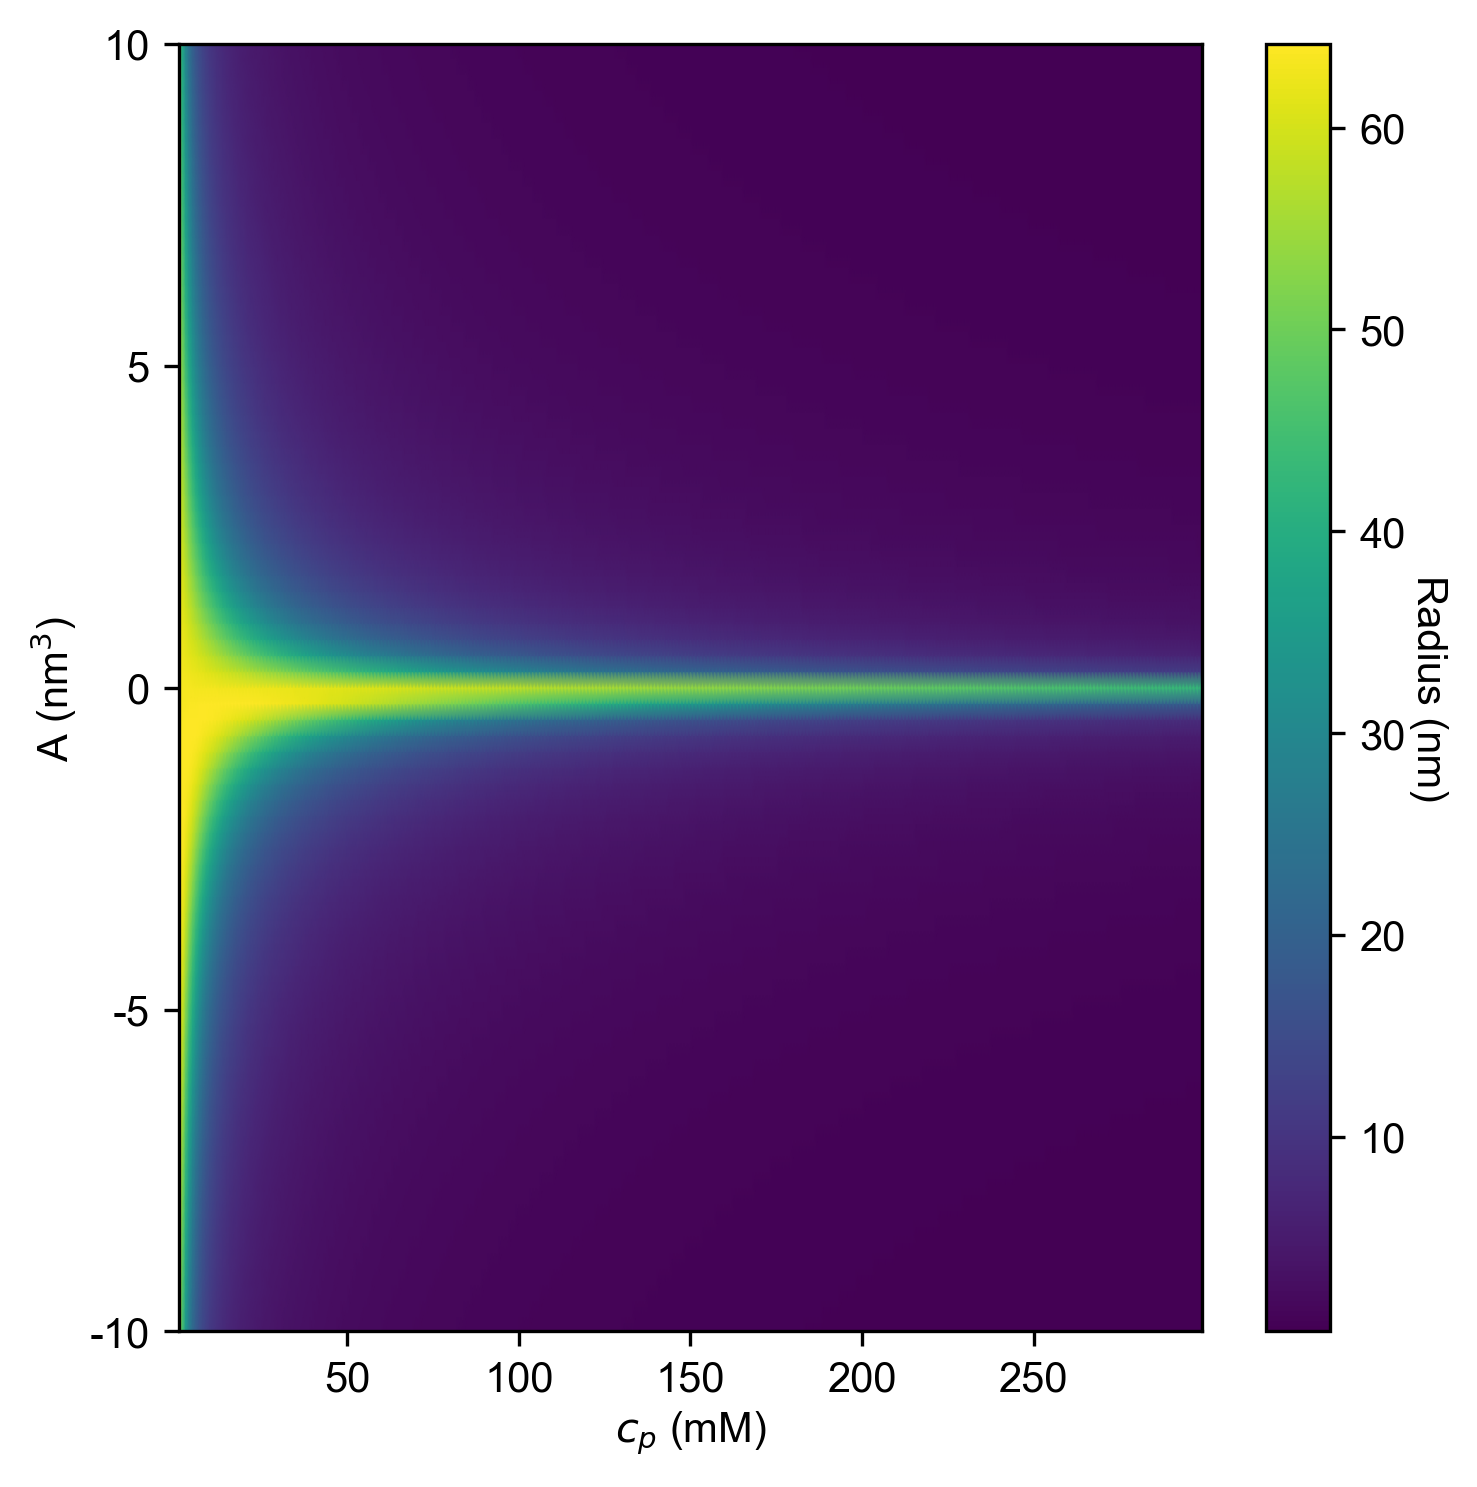

In [8]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

figName = f"phase_map_radius"

if plot3D:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
else:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))


cps = np.arange(1, 300, 1)
As = np.arange(-10, 10.5, 0.25)

# print(len(cps), len(As))
Z = np.zeros(
    (
        len(As),
        len(cps),
    )
)

for i, cp in enumerate(cps):
    for j, A in enumerate(As):
        c0 = (
            computeForce(cp=cp, A=A, phi=150, i=1, a=1.0, alpha=0.1, B=0, d=20, N=600)
            / kappa
        )
        Z[j, i] = 1 / np.sqrt(c0 * c0 + 2 * tension / (kappa * 4.114))

cp, A = np.meshgrid(cps, As)

if plot3D:
    surf = ax.plot_surface(
        cp,
        A,
        Z,
        cmap=cm.viridis,
        rstride=1,
        cstride=1,
        linewidth=0.1,
        antialiased=True,
        edgecolor="k",
    )
    # Set non-default view
    ax.view_init(elev=40, azim=40, roll=10)
else:
    surf = ax.pcolormesh(cp, A, Z, cmap=cm.viridis, shading="gouraud", rasterized=True)

# surf = ax.contour3D(cp, A, Z, 100, cmap=cm.RdYlGn)


ax.set_xlabel(r"$c_p$ (mM)")

ax.set_ylim((-10, 10))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")

if plot3D:
    # ax.set_zlim(-5,5)
    ax.set_zlabel(r"R (nm)")
    ax.zaxis.set_major_formatter("{x:.0f}")
    ax.zaxis.labelpad = 0
else:
    cbar = fig.colorbar(
        surf,
        ax=ax,
    )

cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel("Radius (nm)", rotation=270)

fig.tight_layout()


fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


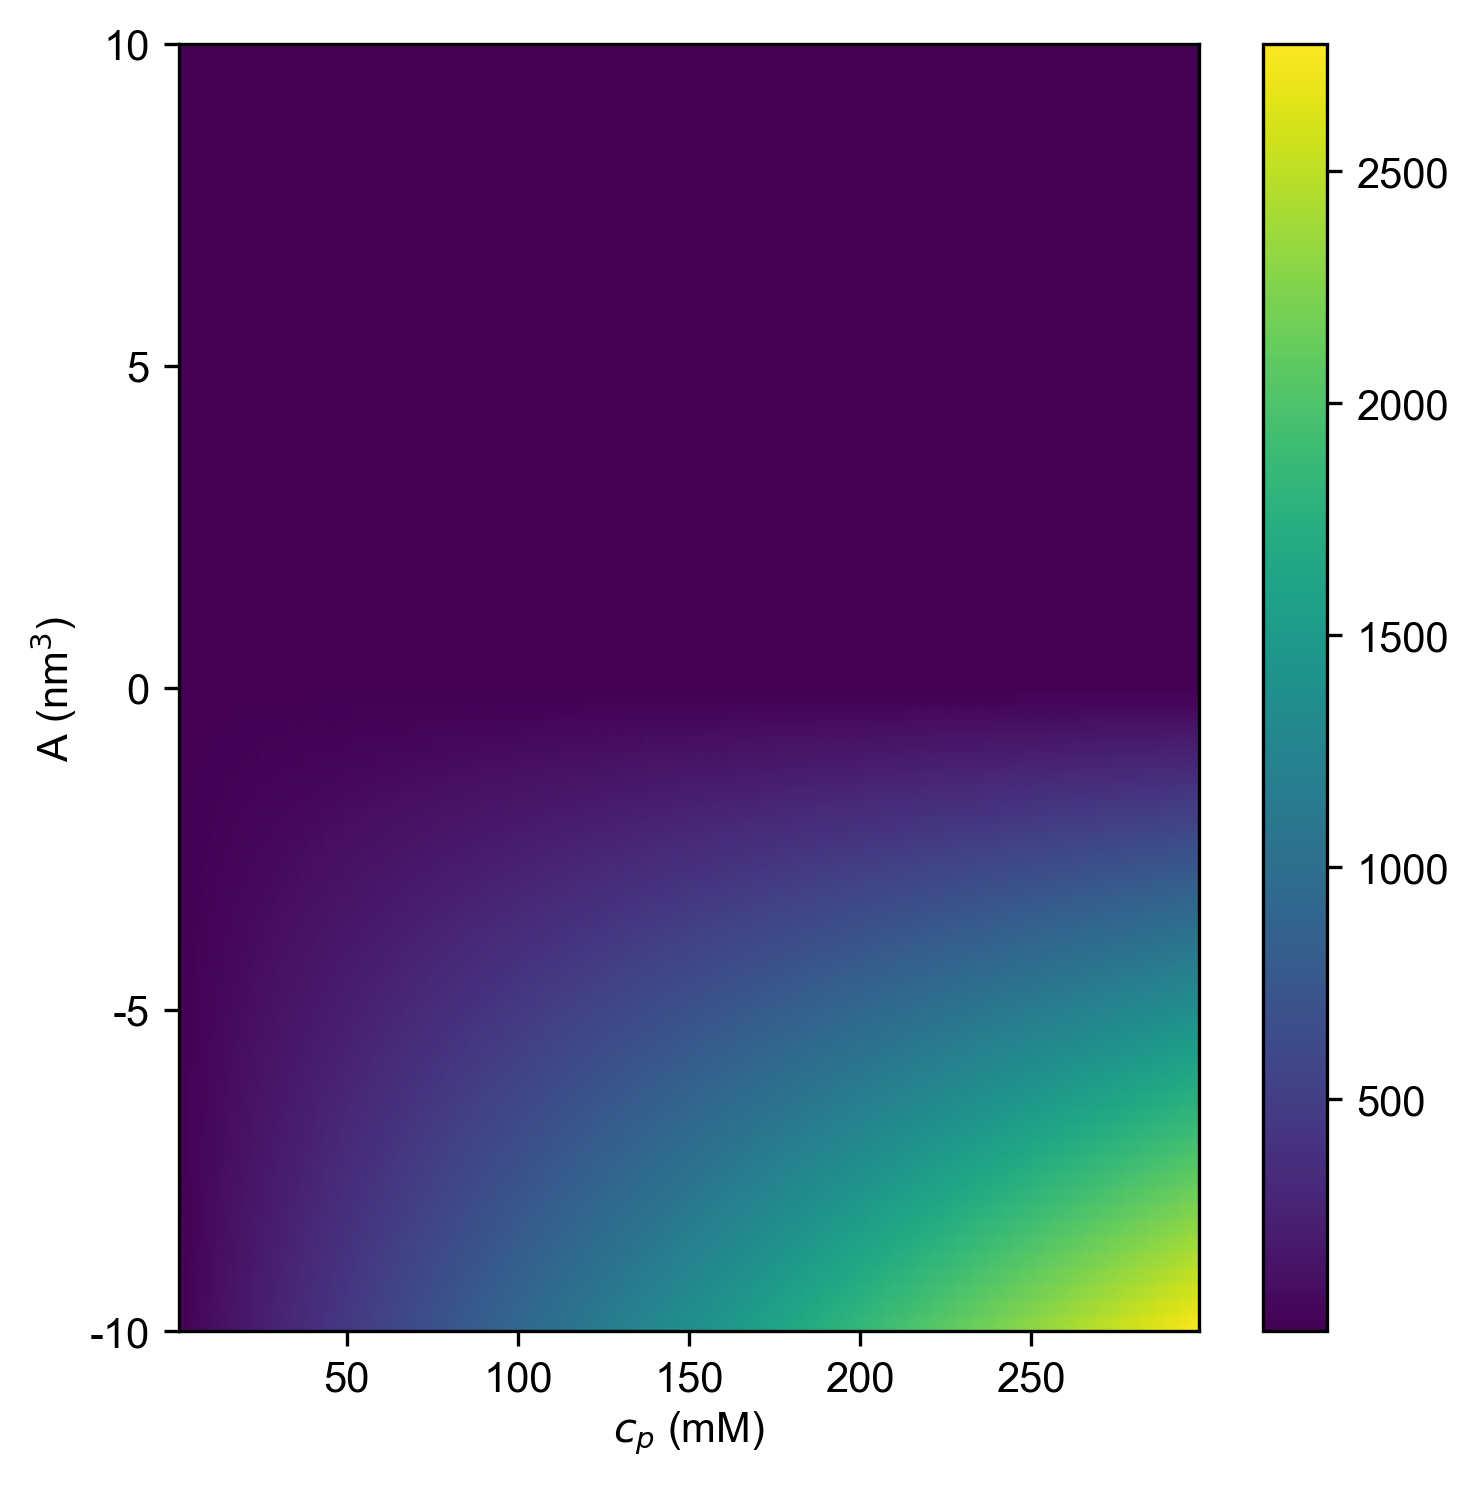

In [9]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

figName = f"phase_map_length"

if plot3D:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
else:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cps = np.arange(1, 300, 1)
As = np.arange(-10, 10.5, 0.25)

# print(len(cps), len(As))
Z = np.zeros(
    (
        len(As),
        len(cps),
    )
)

for i, cp in enumerate(cps):
    for j, A in enumerate(As):
        c0 = (
            computeForce(cp=cp, A=A, phi=150, i=1, a=1.0, alpha=0.1, B=0, d=20, N=600)
            / kappa
        )
        Z[j, i] = (
            2
            * np.pi
            * kappa
            * 4.114
            * (np.sqrt(c0 * c0 + 2 * tension / (kappa * 4.114)) - c0)
        )

cp, A = np.meshgrid(cps, As)

if plot3D:
    surf = ax.plot_surface(
        cp, A, Z, cmap=cm.viridis, linewidth=0.1, antialiased=True, edgecolor="k"
    )
    # surf = ax.contour3D(cp, A, Z, 100, cmap=cm.RdYlGn)
else:
    surf = ax.pcolormesh(cp, A, Z, cmap=cm.viridis, shading="gouraud", rasterized=True)

ax.set_xlabel(r"$c_p$ (mM)")

ax.set_ylim((-10, 10))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")


cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel("Force (pN)", rotation=270)

if plot3D:
    # ax.set_zlim(-5,5)
    ax.set_zlabel(r"f (pN)")
    ax.zaxis.set_major_formatter("{x:.0f}")
    ax.zaxis.labelpad = 0
else:
    cbar = fig.colorbar(
        surf,
        ax=ax,
    )

fig.tight_layout()


fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


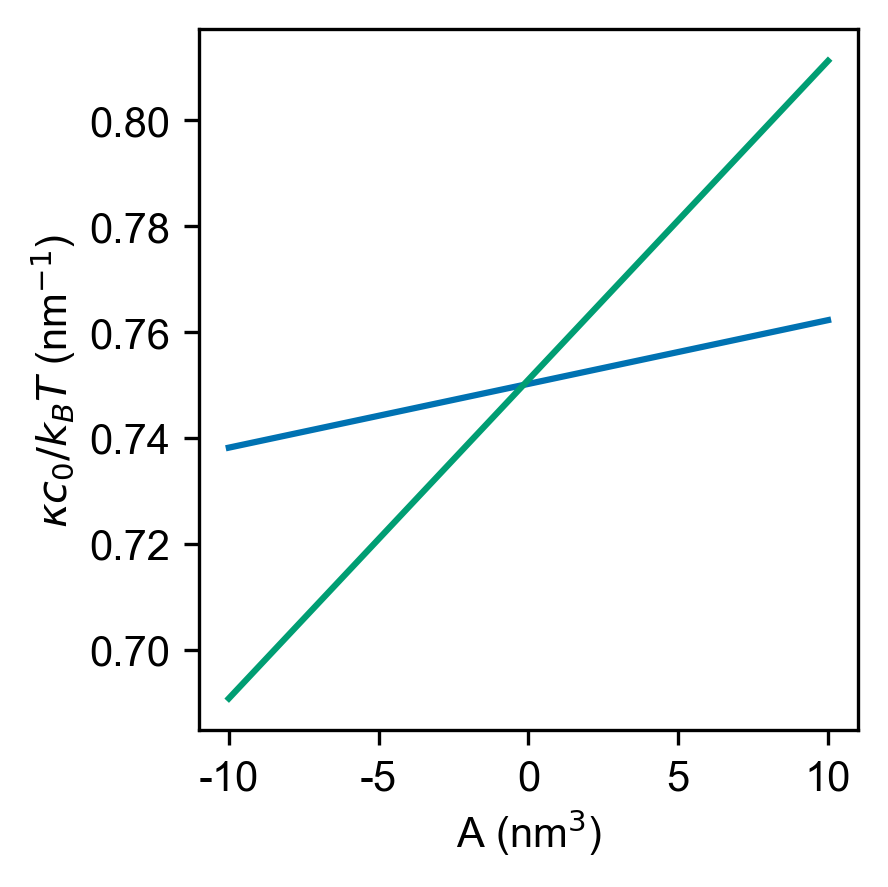

In [10]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

As = np.arange(-10, 10.5, 0.5)
kcc0 = np.zeros(len(As))
kcc02 = np.zeros(len(As))

for i, A in enumerate(As):
    kcc0[i] = computeForce(cp=1, phi=50, i=1, a=1.0, alpha=0.1, A=A, B=0, N=600, d=300)
    kcc02[i] = computeForce(cp=5, phi=50, i=1, a=1.0, alpha=0.1, A=A, B=0, N=600, d=300)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(As, kcc0)
ax.plot(As, kcc02)

ax.set_xlabel(r"A (nm$^{3}$)")
ax.set_ylabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
fig.tight_layout()

figName = f"varied_cp"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


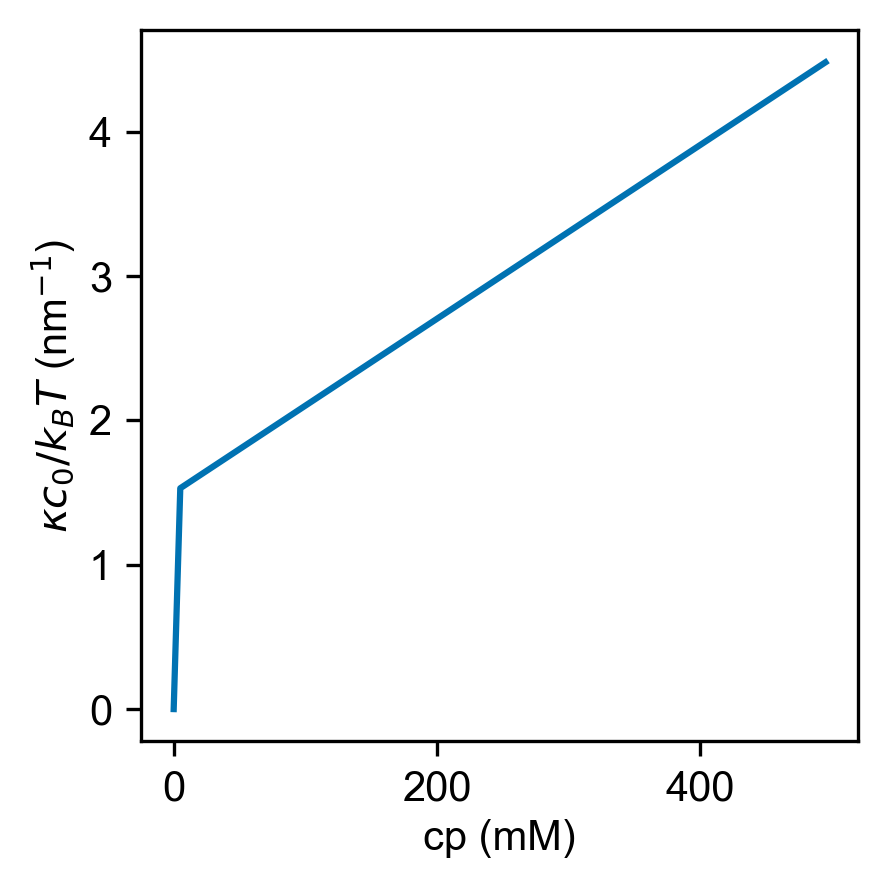

In [11]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

cps = np.arange(0, 500, 5)
kcc0 = np.zeros(len(cps))

for i, cp in enumerate(cps):
    kcc0[i] = computeForce(cp=cp, phi=0, i=1, a=1.0, alpha=0.1, A=10, B=0, N=300, d=300)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(cps, kcc0)

ax.set_xlabel(r"cp (mM)")
ax.set_ylabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
fig.tight_layout()

figName = f"varied_cp"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


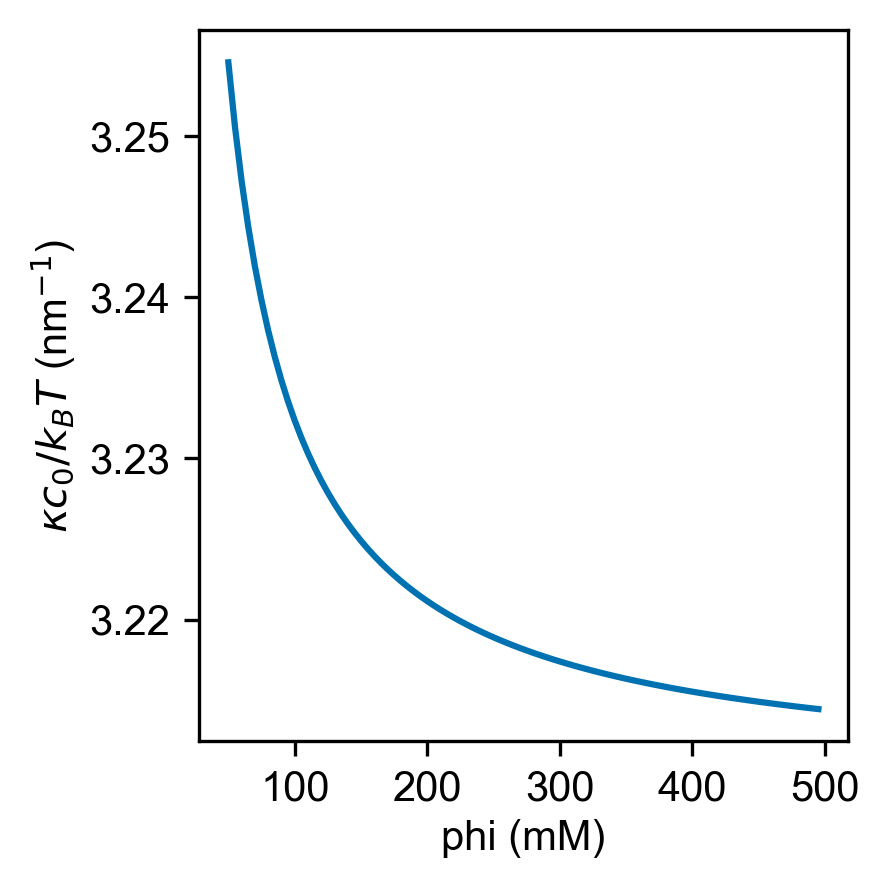

In [12]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(50, 500, 5)
kcc0 = np.zeros(len(phis))

for i, phi in enumerate(phis):
    kcc0[i] = computeForce(
        cp=150, phi=phi, i=1, a=1.0, alpha=0.1, A=10, B=0, N=300, d=100
    )

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(phis, kcc0)

ax.set_xlabel(r"phi (mM)")
ax.set_ylabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
fig.tight_layout()

figName = f"varied_phis"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


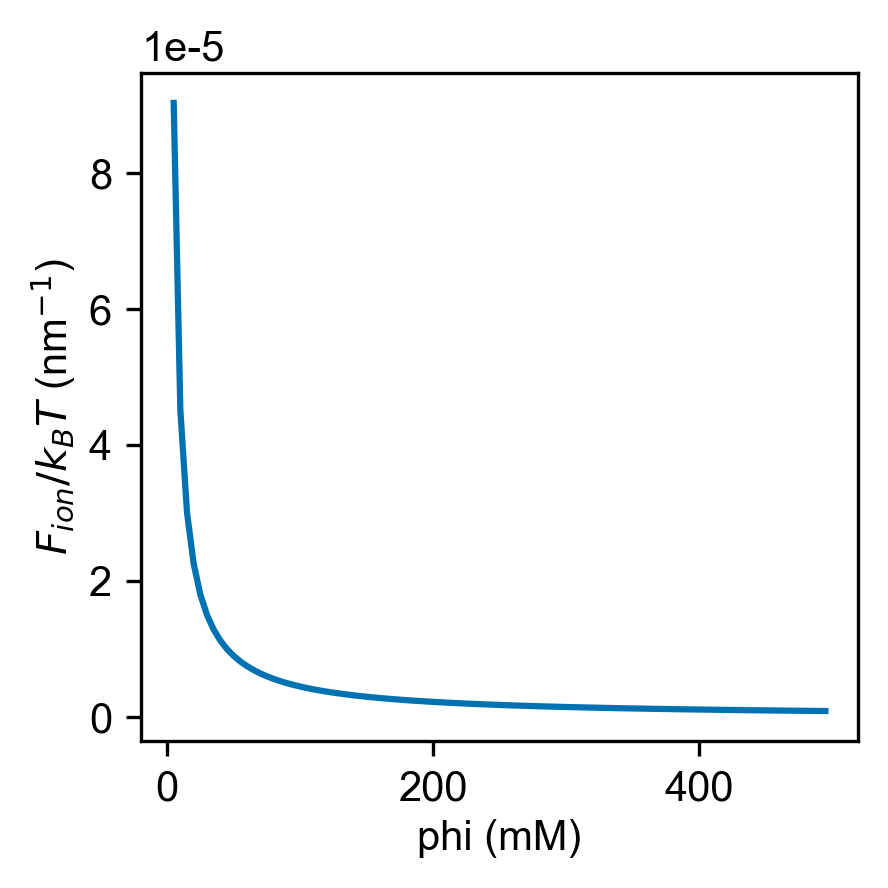

In [13]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(5, 500, 5)
fion = np.zeros(len(phis))

alpha = 0.1
cp = milliMolarToNumberDensity(100)

N = 300
d = 200

s0 = N / (d * cp)

for i, phi in enumerate(phis):
    acop = alpha * cp / phi
    sopacop2 = np.sqrt(1 + acop * acop)
    fion[i] = (-(sopacop2 - 1) * phi - alpha * cp * np.log(sopacop2 - acop)) * s0

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.plot(phis, fion)

ax.set_xlabel(r"phi (mM)")
ax.set_ylabel(r"$F_{ion}/k_BT$ (nm$^{-1}$)")
fig.tight_layout()

figName = f"fion"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


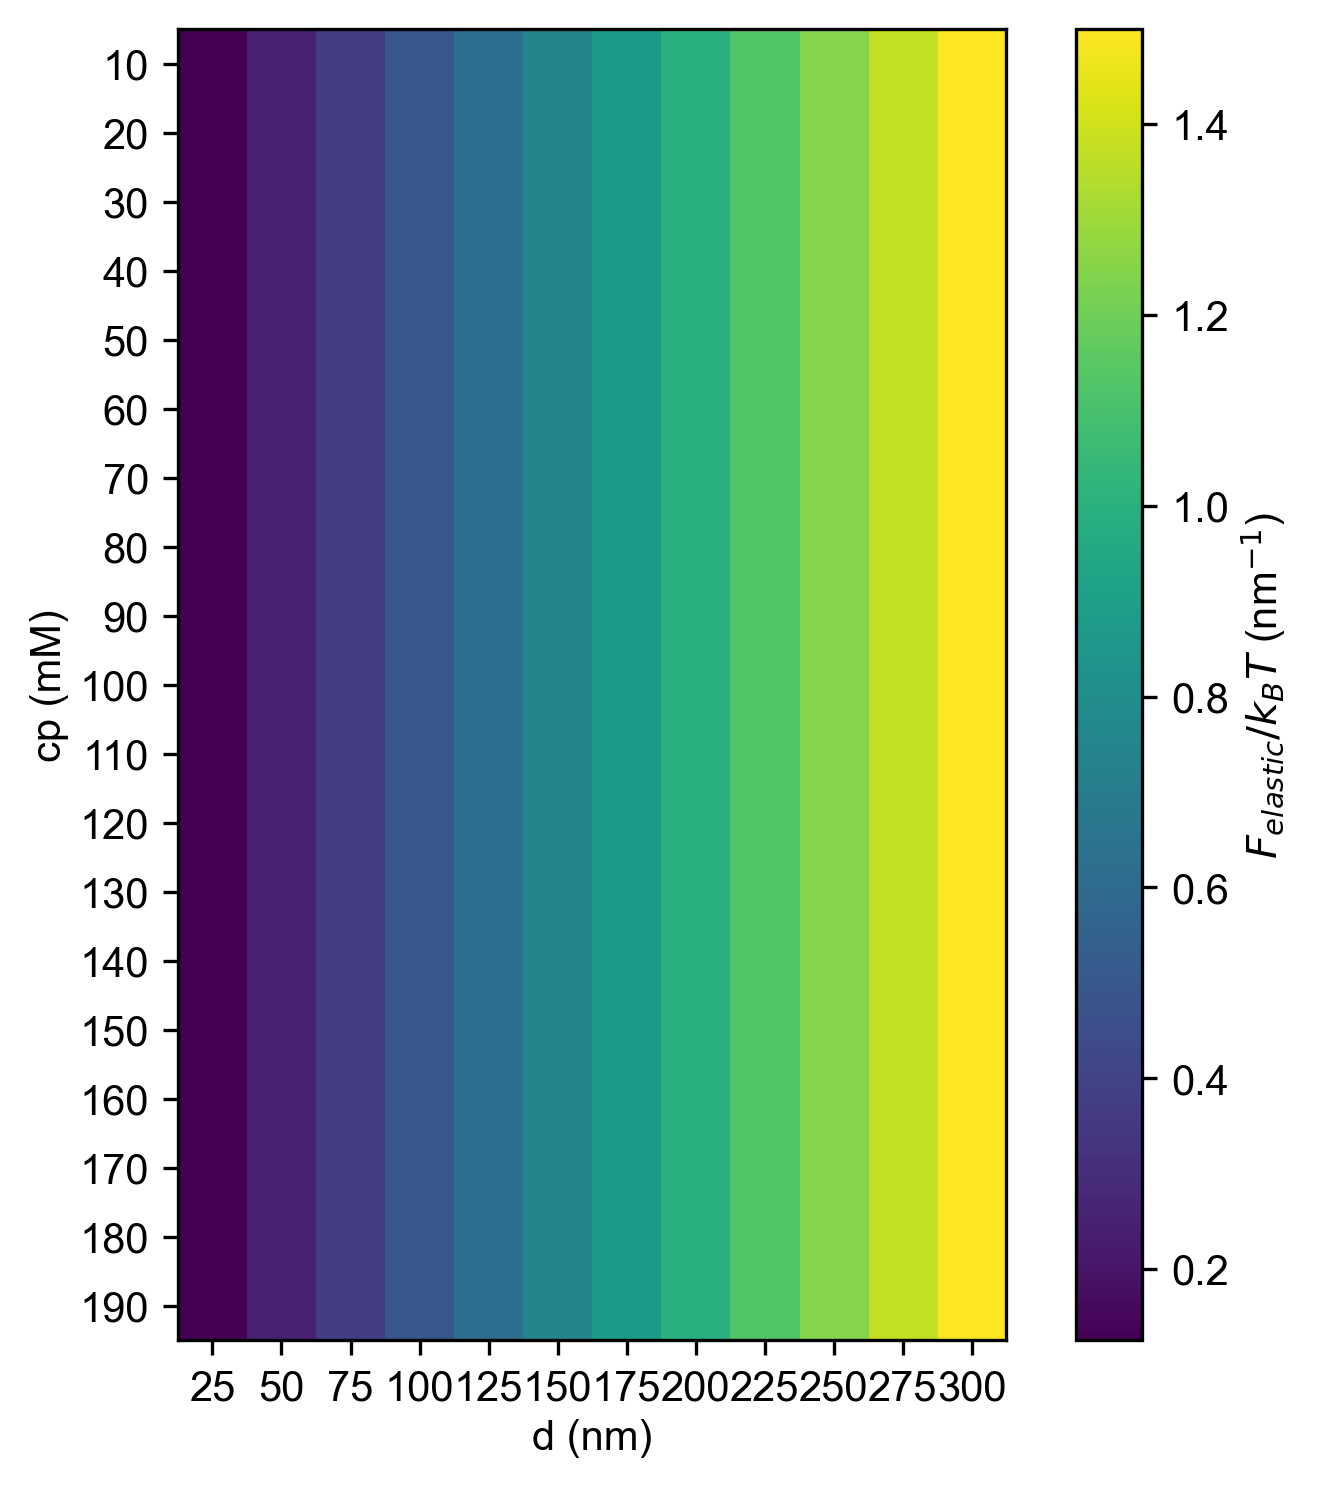

In [14]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(5, 500, 5)
fion = np.zeros(len(phis))

alpha = 0.1

N = 300
a = 1.0

cps = np.arange(10, 200, 10)
ds = np.arange(25, 325, 25)

data = np.zeros((len(cps), len(ds)))

for i, cpi in enumerate(cps):
    cp = milliMolarToNumberDensity(cpi)
    for j, d in enumerate(ds):
        s0 = N / (d * cp)
        data[i, j] = 1.5 / (cp * s0 * a * a)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = ax.imshow(data)

cbar = ax.figure.colorbar(
    im,
    ax=ax,
)

cbar.set_label(r"$F_{elastic}/k_BT$ (nm$^{-1}$)")

ax.set_yticks(np.arange(len(cps)), cps)
ax.set_xticks(np.arange(len(ds)), ds)

ax.set_xlabel(r"d (nm)")
ax.set_ylabel(r"cp (mM)")
fig.tight_layout()

figName = f"elastic"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


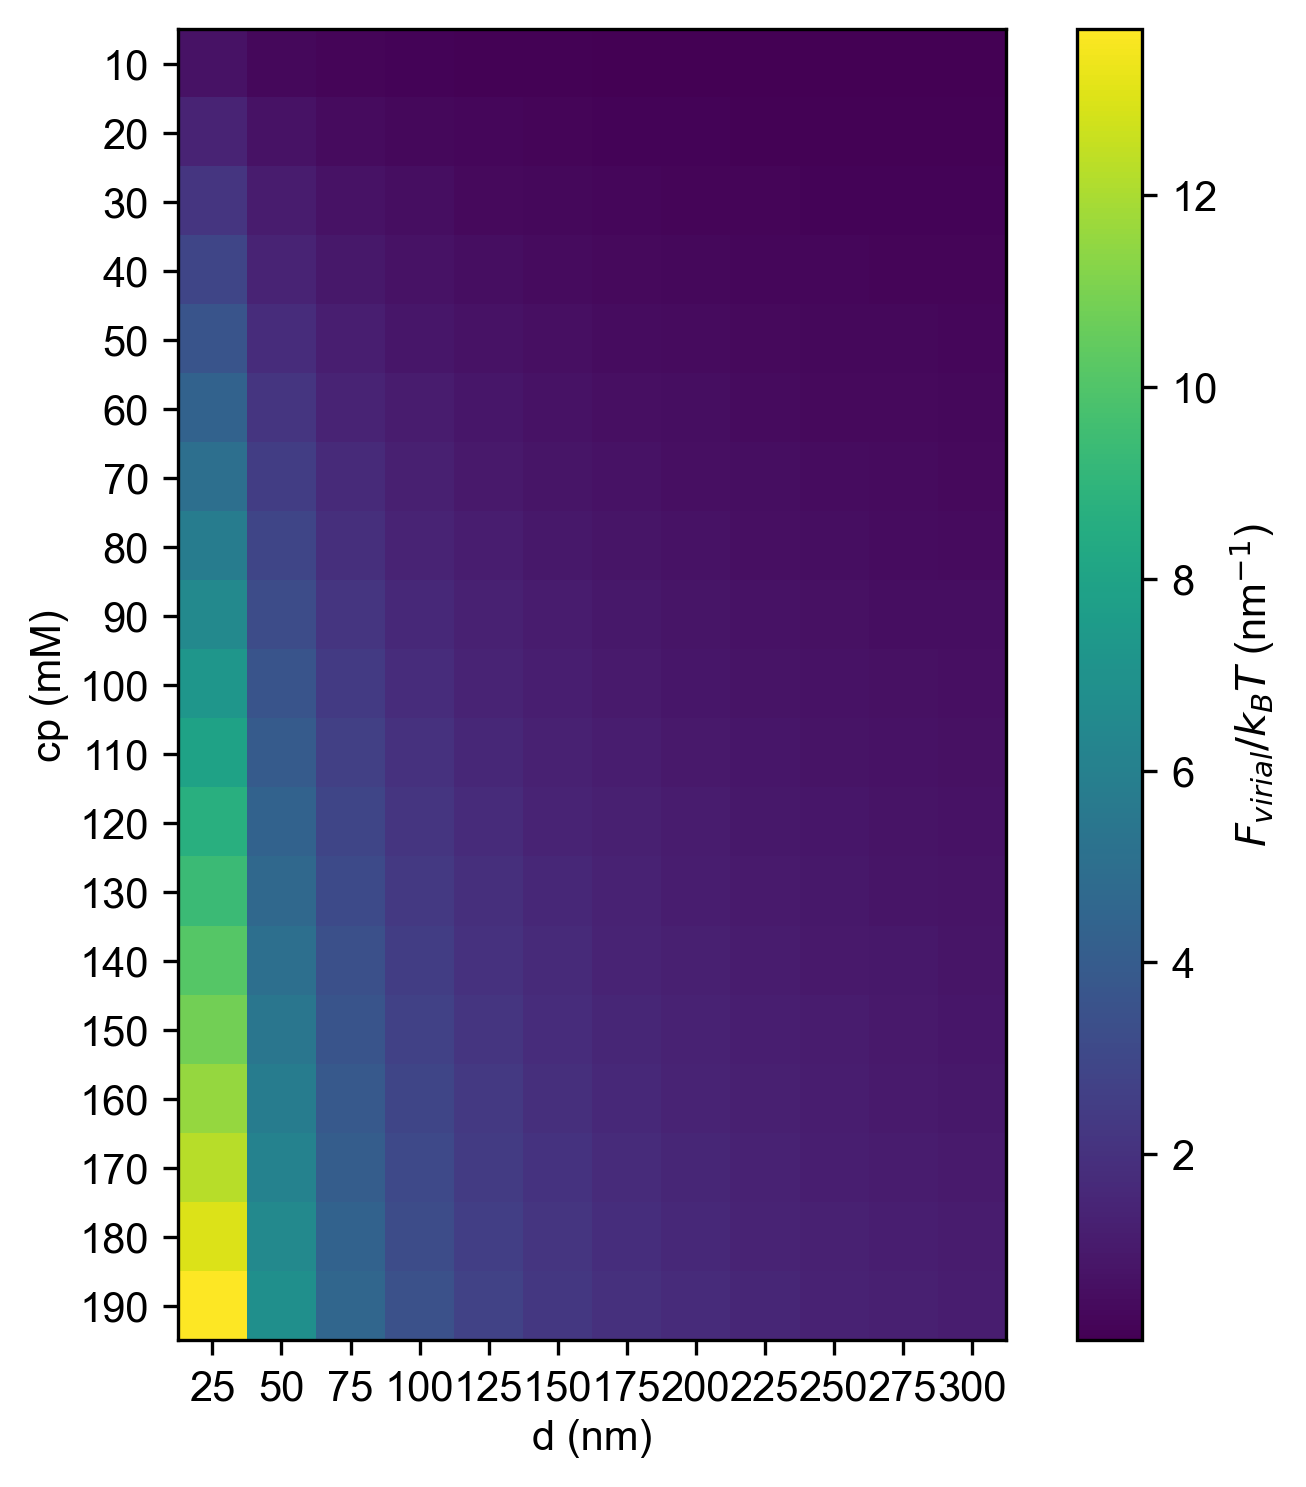

In [15]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

phis = np.arange(5, 500, 5)
fion = np.zeros(len(phis))

alpha = 0.1

N = 300
a = 1.0

A = 10
B = 0

cps = np.arange(10, 200, 10)
ds = np.arange(25, 325, 25)

data = np.zeros((len(cps), len(ds)))

for i, cpi in enumerate(cps):
    cp = milliMolarToNumberDensity(cpi)
    for j, d in enumerate(ds):
        s0 = N / (d * cp)
        data[i, j] = (A * cp * cp + B * cp * cp * cp) * s0

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = ax.imshow(data)

cbar = ax.figure.colorbar(
    im,
    ax=ax,
)

cbar.set_label(r"$F_{virial}/k_BT$ (nm$^{-1}$)")

ax.set_yticks(np.arange(len(cps)), cps)
ax.set_xticks(np.arange(len(ds)), ds)

ax.set_xlabel(r"d (nm)")
ax.set_ylabel(r"cp (mM)")
fig.tight_layout()

figName = f"virial"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


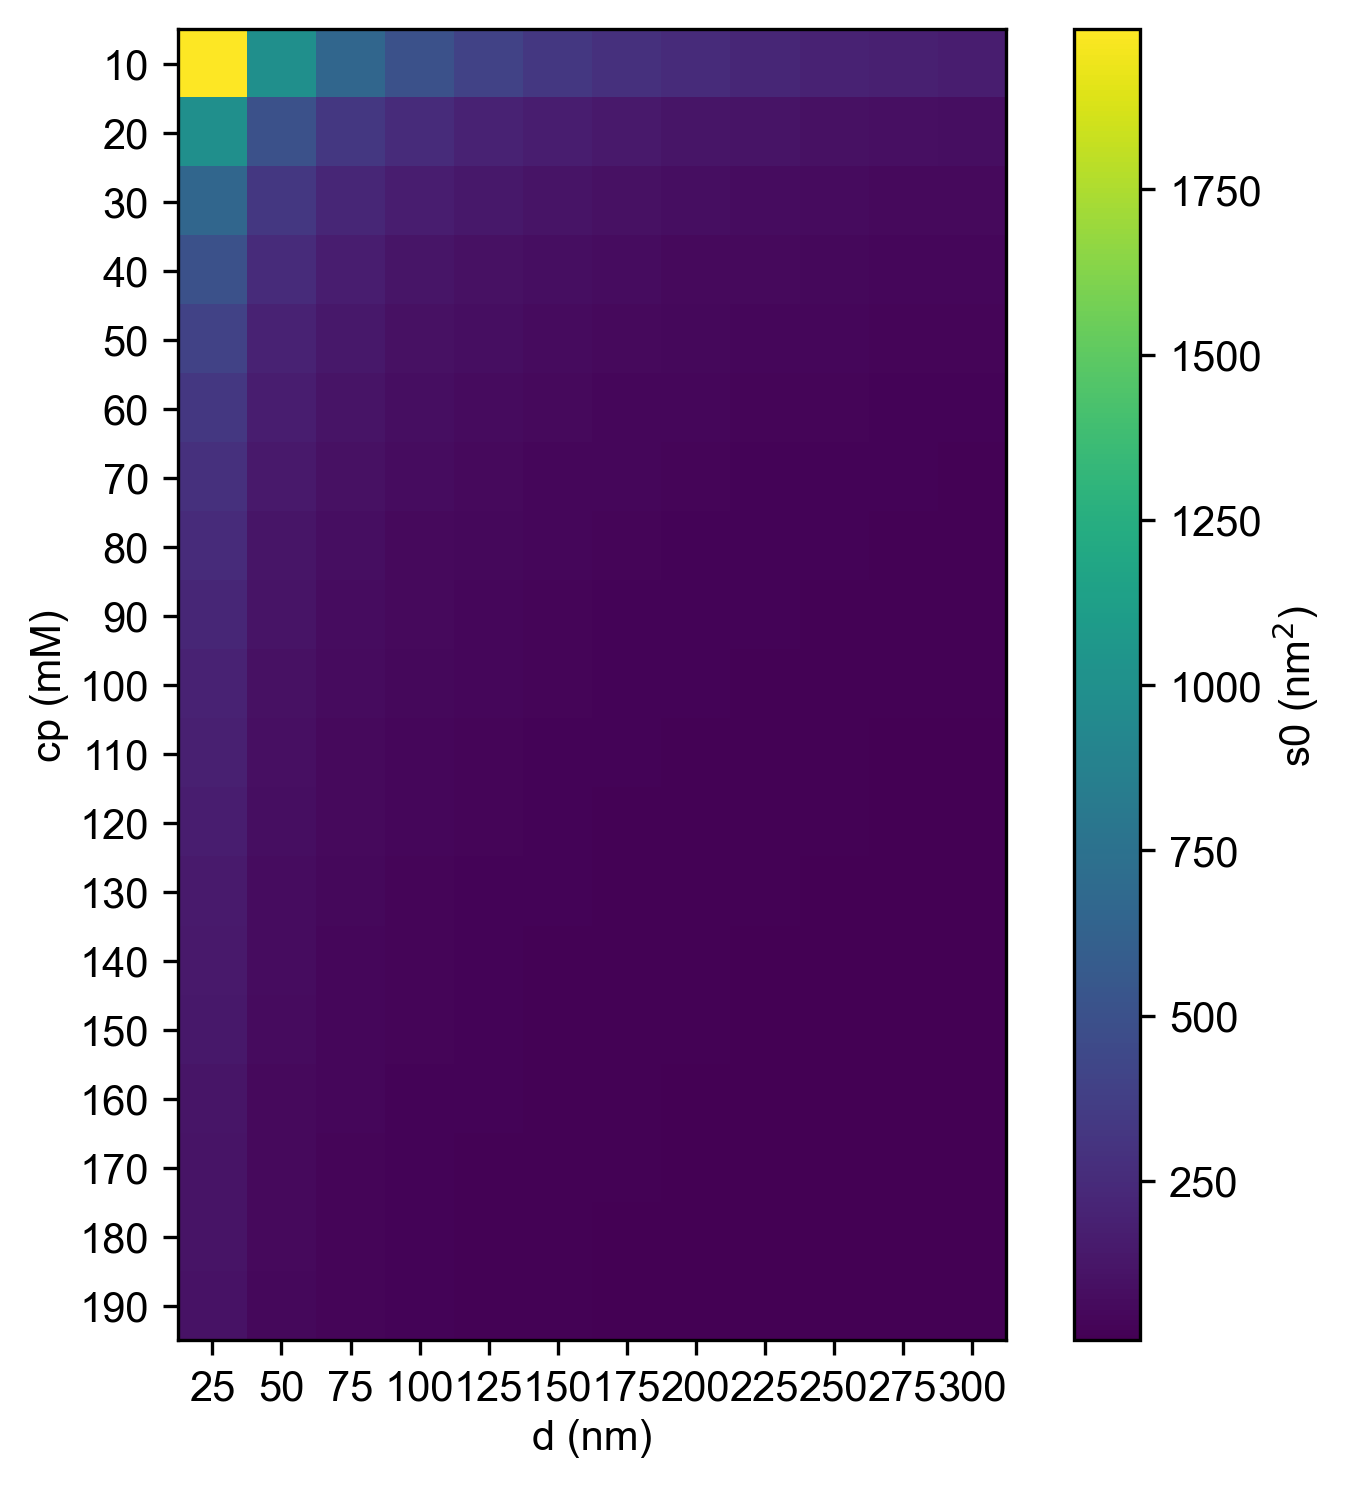

In [16]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

alpha = 0.1

N = 300
a = 1.0


cps = np.arange(10, 200, 10)
ds = np.arange(25, 325, 25)

data = np.zeros((len(cps), len(ds)))

for i, cpi in enumerate(cps):
    cp = milliMolarToNumberDensity(cpi)
    for j, d in enumerate(ds):
        data[i, j] = N / (d * cp)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = ax.imshow(data)

cbar = ax.figure.colorbar(
    im,
    ax=ax,
)

cbar.set_label(r"s0 (nm$^{2}$)")

ax.set_yticks(np.arange(len(cps)), cps)
ax.set_xticks(np.arange(len(ds)), ds)

ax.set_xlabel(r"d (nm)")
ax.set_ylabel(r"cp (mM)")
fig.tight_layout()

figName = f"area"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)
